In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import optuna
import numpy as np
from scipy import stats

# Set the Optuna logger to output only WARNING and higher levels
optuna.logging.set_verbosity(optuna.logging.WARNING)

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

/Users/user/anaconda3/envs/GIGACOW/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/XGBMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,DailyYieldChange,ExpectedYield,NormalizedDailyYield,NormalizedDailyYieldChange,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-01-01,a624fb9a,SE-064c0cec-1189,3095,7.0,191.0,2022-1,30.77,0.00,0.00,29.739372,1.034655,0.000000,0,0,0,0,-3.025000,28.012944,NaN
1,2022-01-02,a624fb9a,SE-064c0cec-1189,3096,7.0,192.0,2022-1,48.22,30.77,17.45,29.692059,1.624003,0.587699,0,0,0,0,-0.279167,32.898193,NaN
2,2022-01-03,a624fb9a,SE-064c0cec-1189,3097,7.0,193.0,2022-1,30.53,48.22,-17.69,29.644756,1.029862,-0.596733,0,0,0,0,2.033333,36.760487,NaN
3,2022-01-04,a624fb9a,SE-064c0cec-1189,3098,7.0,194.0,2022-1,42.26,30.53,11.73,29.597463,1.427825,0.396318,0,0,0,0,0.066667,31.939524,NaN
4,2022-01-05,a624fb9a,SE-064c0cec-1189,3099,7.0,195.0,2022-1,38.49,42.26,-3.77,29.550181,1.302530,-0.127580,0,0,0,0,-3.700000,26.498206,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487083,2023-06-03,f454e660,SE-fcdf259d-0044-0,4150,10.0,347.0,2023-3,12.67,15.75,-3.08,11.811455,1.072687,-0.260764,0,1,0,0,12.666667,53.132530,NaN
487084,2023-06-04,f454e660,SE-fcdf259d-0044-0,4151,10.0,348.0,2023-3,22.31,12.67,9.64,11.750492,1.898644,0.820391,0,1,0,0,13.079167,56.726870,NaN
487085,2023-06-05,f454e660,SE-fcdf259d-0044-0,4152,10.0,349.0,2023-3,12.84,22.31,-9.47,11.689810,1.098393,-0.810107,0,1,0,0,14.237500,58.482418,NaN
487086,2023-06-06,f454e660,SE-fcdf259d-0044-0,4153,10.0,350.0,2023-3,9.47,12.84,-3.37,11.629408,0.814315,-0.289783,0,1,0,0,15.345833,60.546358,NaN


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-064c0cec-1189,0.025289,1.011878,-0.014983
1,SE-30dc5787-1389,0.040313,0.950087,0.046997
2,SE-30dc5787-1396,0.043003,0.974895,0.022113
3,SE-30dc5787-1402,0.072737,0.908831,0.088381
4,SE-a624fb9a-1039,0.043271,0.917030,0.080156
...,...,...,...,...
128,SE-a624fb9a-1490,0.028791,0.869332,0.128000
129,SE-a624fb9a-1491,0.035823,0.954721,0.042349
130,SE-a624fb9a-1493,0.221511,1.068282,-0.071560
131,SE-a624fb9a-1496,0.016122,0.926555,0.070601


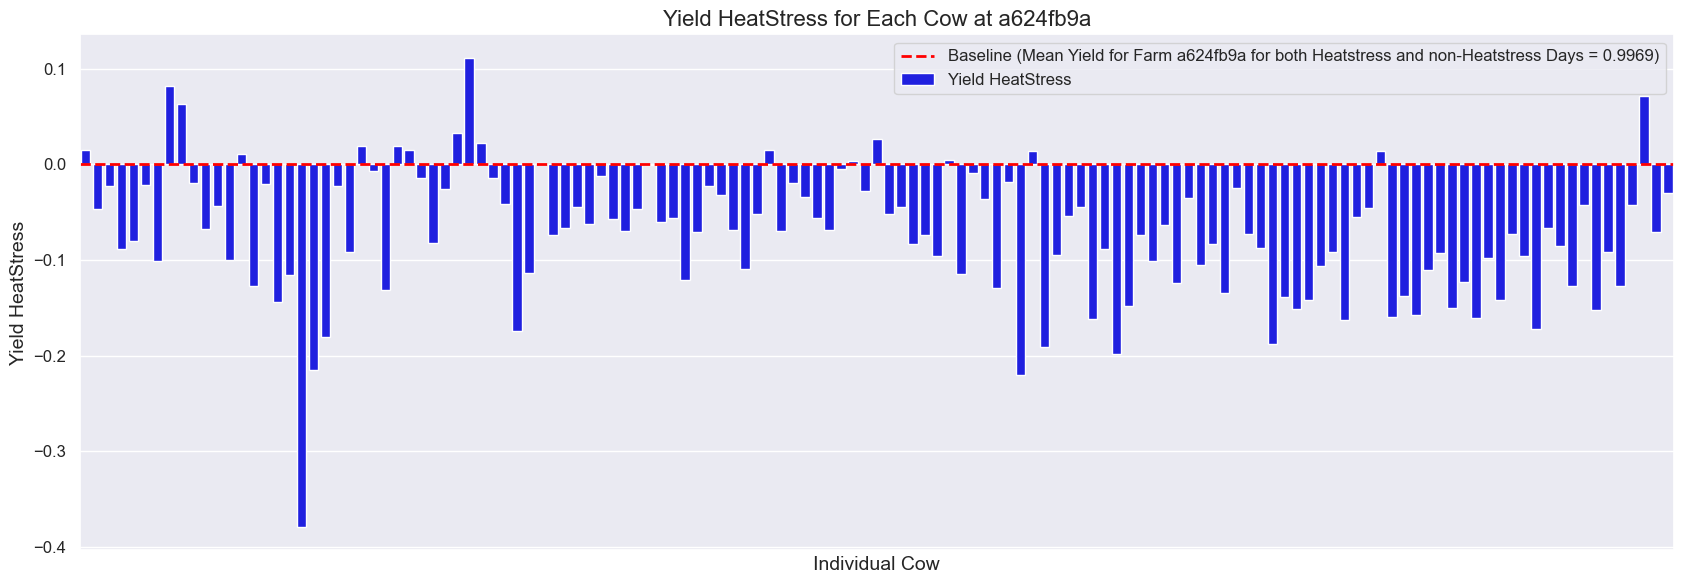

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

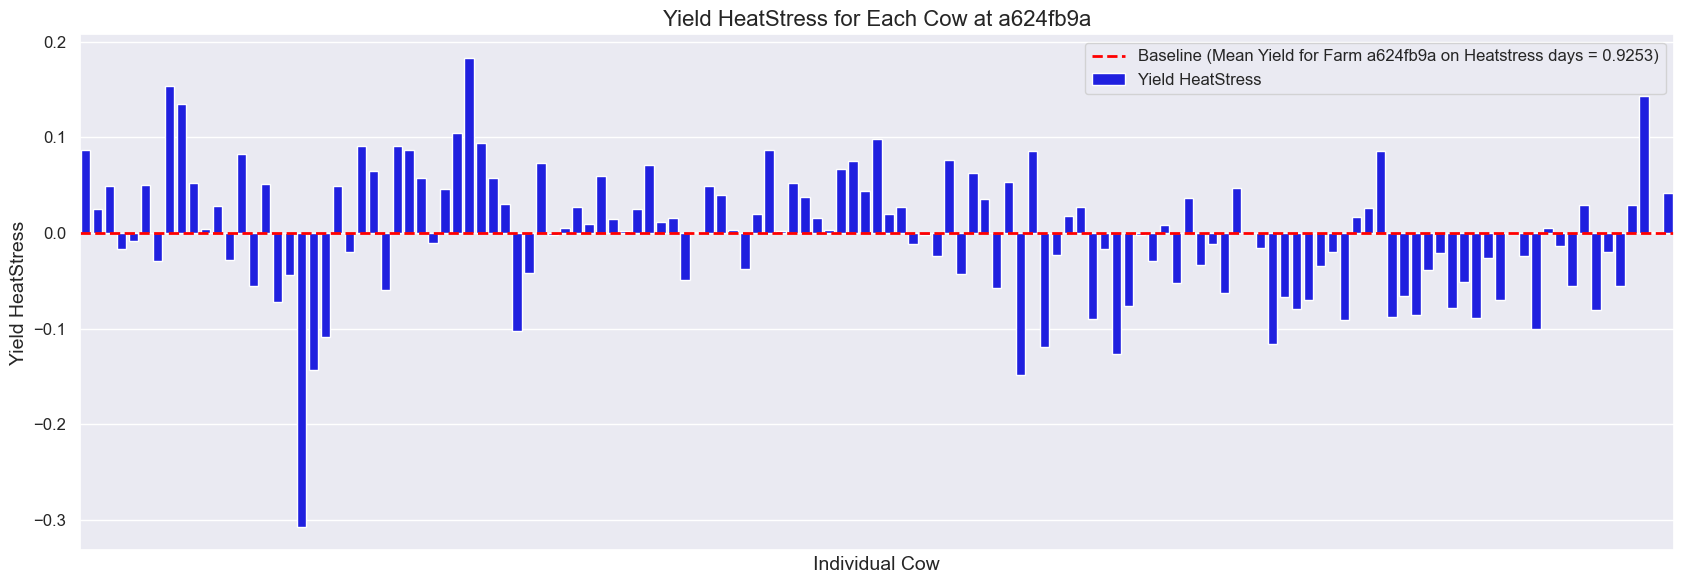

In [5]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for Farm {farm} on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Farm 5c06d92d

In [7]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-5c06d92d-2000,0.036050,0.863073,0.133450
1,SE-5c06d92d-2016,0.050212,0.911985,0.084341
2,SE-5c06d92d-2055,0.137895,0.606833,0.390722
3,SE-5c06d92d-2058,0.609127,0.625849,0.371630
4,SE-5c06d92d-2211,0.021788,0.911572,0.084755
...,...,...,...,...
308,SE-5c06d92d-3282,0.070029,0.775008,0.221870
309,SE-5c06d92d-3283,0.099518,0.839166,0.157453
310,SE-5c06d92d-3285,0.064122,0.876779,0.119689
311,SE-5c06d92d-3305,0.150813,0.760727,0.236208


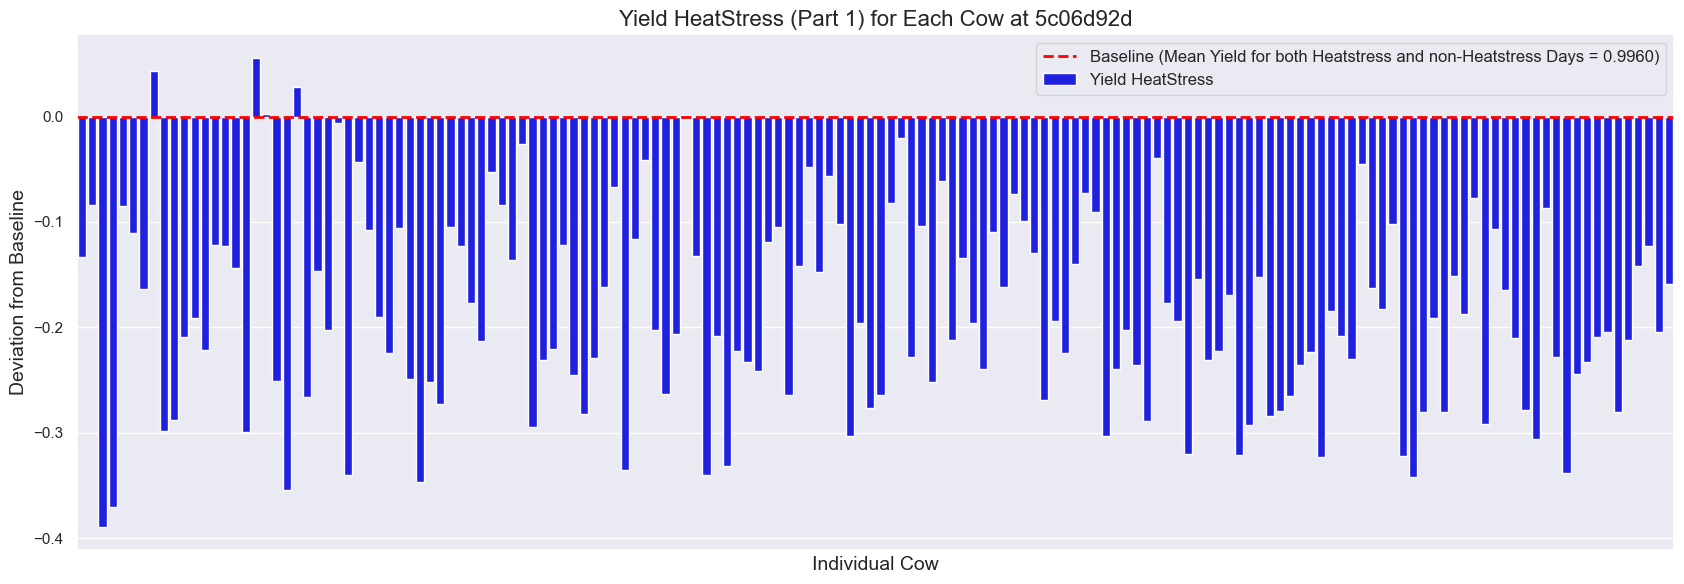

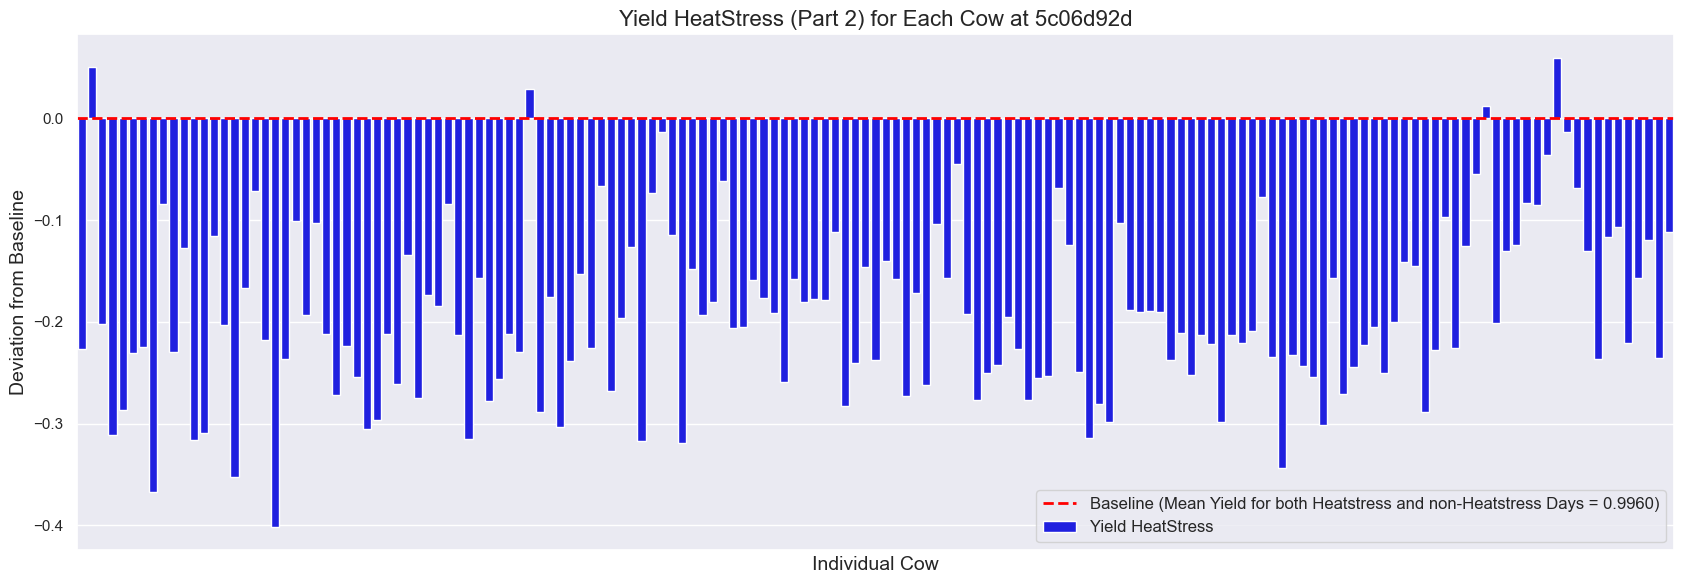

In [8]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

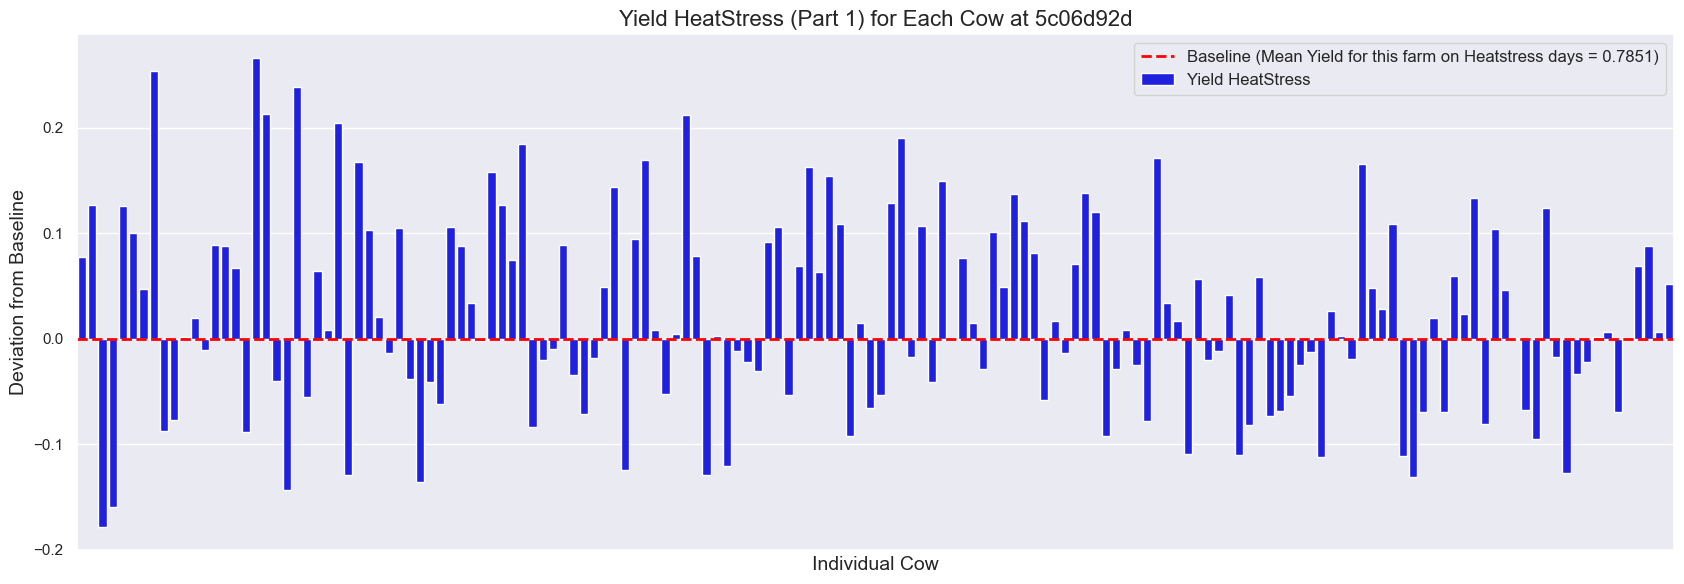

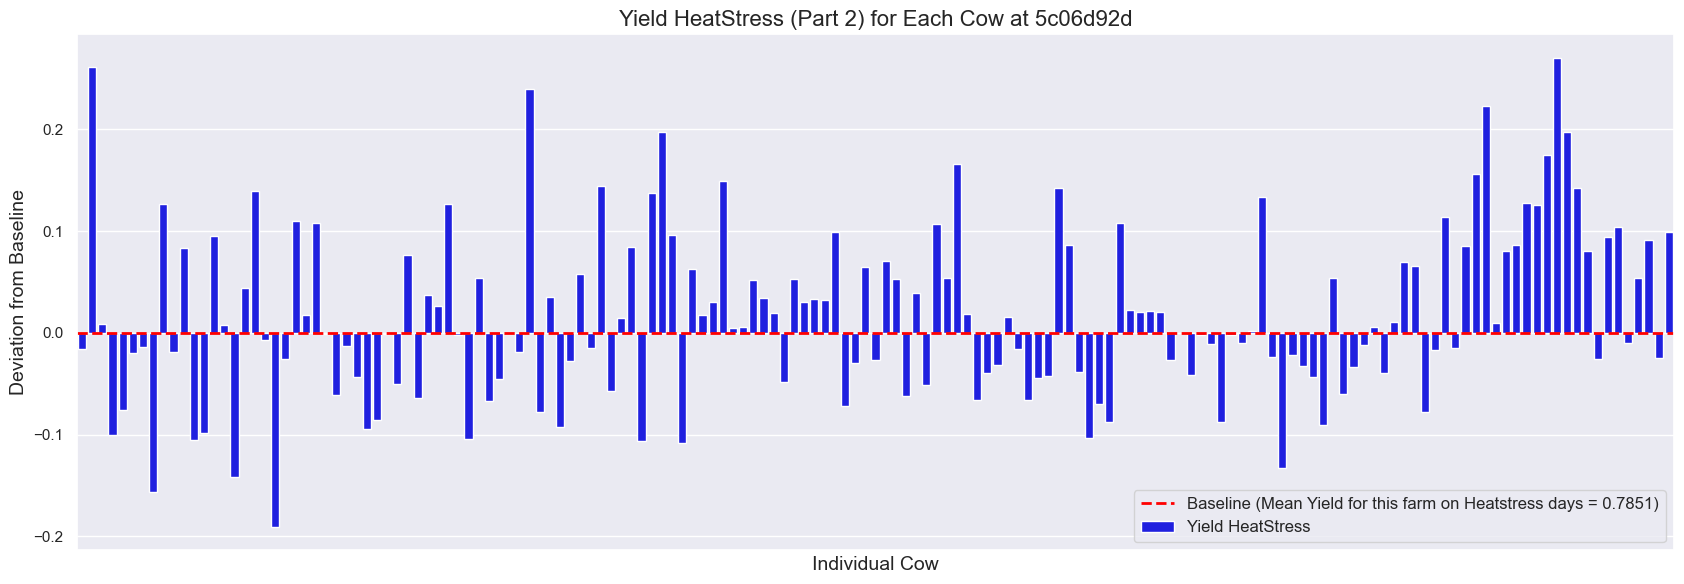

In [9]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72

In [11]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-752efd72-0001,0.013665,0.896296,0.097945
1,SE-752efd72-0002,0.033138,1.083391,-0.090353
2,SE-752efd72-0008,0.018935,0.982223,0.011465
3,SE-752efd72-0010,0.018392,0.799931,0.194928
4,SE-752efd72-0011,0.036171,0.886010,0.108297
...,...,...,...,...
264,SE-752efd72-2793,0.125471,1.008306,-0.014785
265,SE-752efd72-2794,0.010633,0.914052,0.080075
266,SE-752efd72-2795,0.056973,0.809032,0.185769
267,SE-752efd72-2796,0.009411,0.969193,0.024579


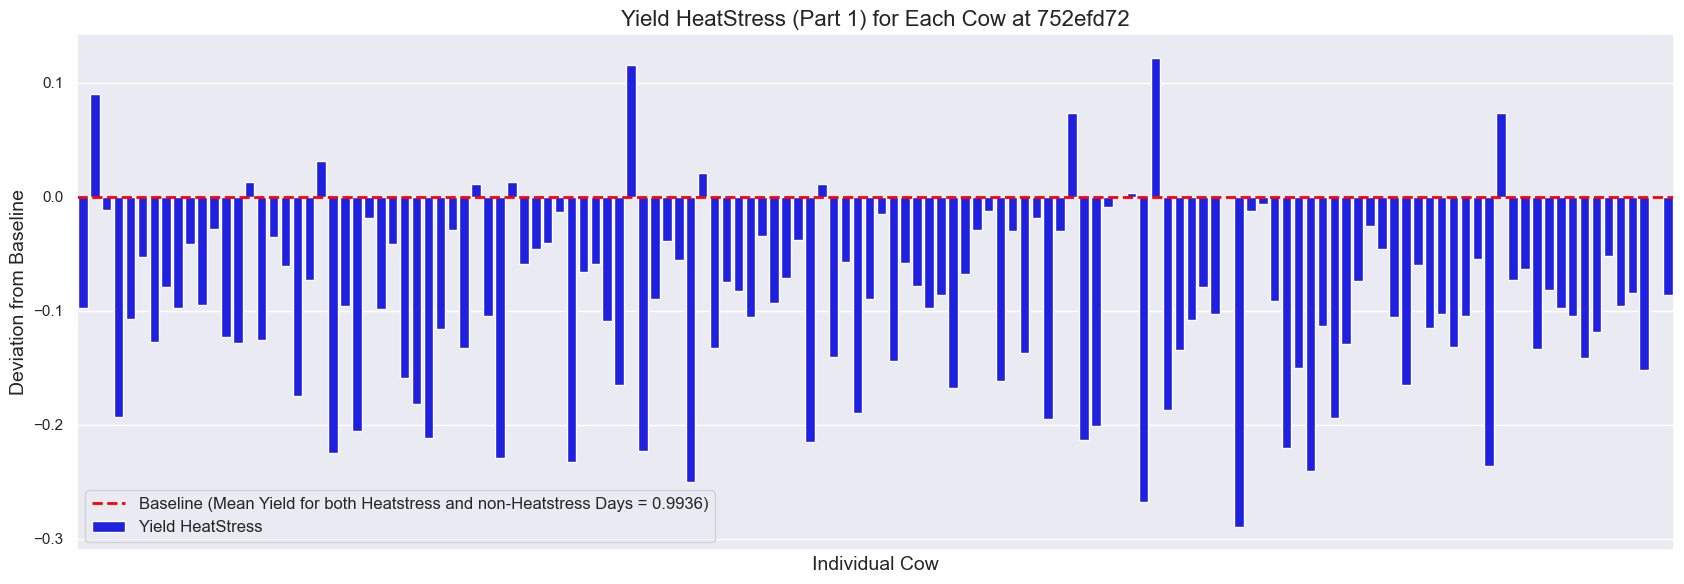

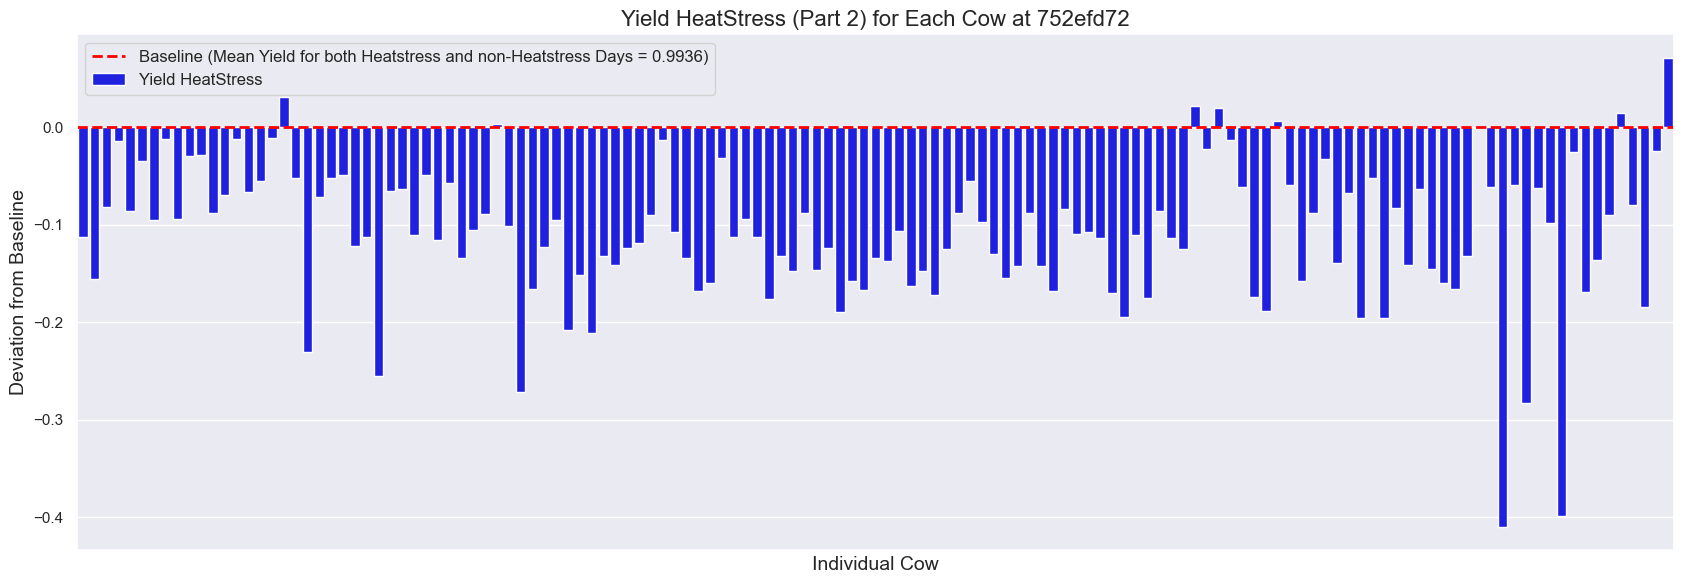

In [12]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

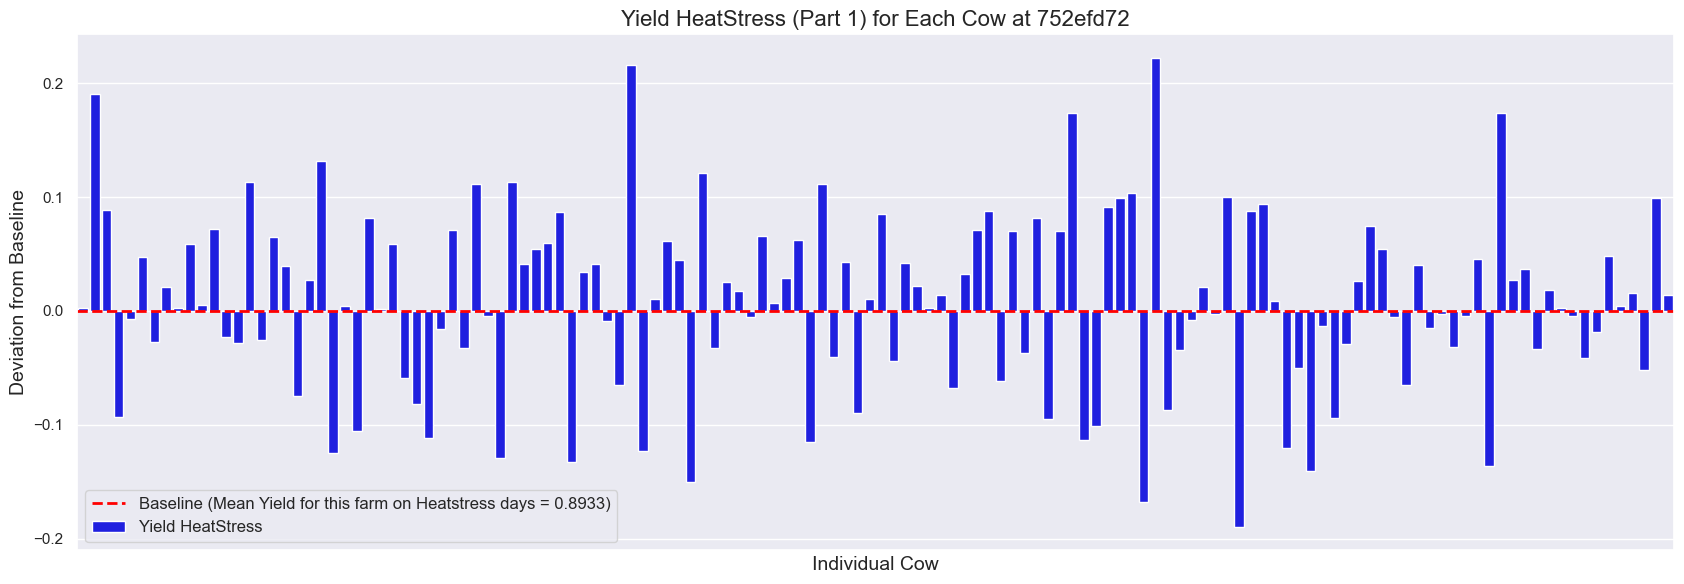

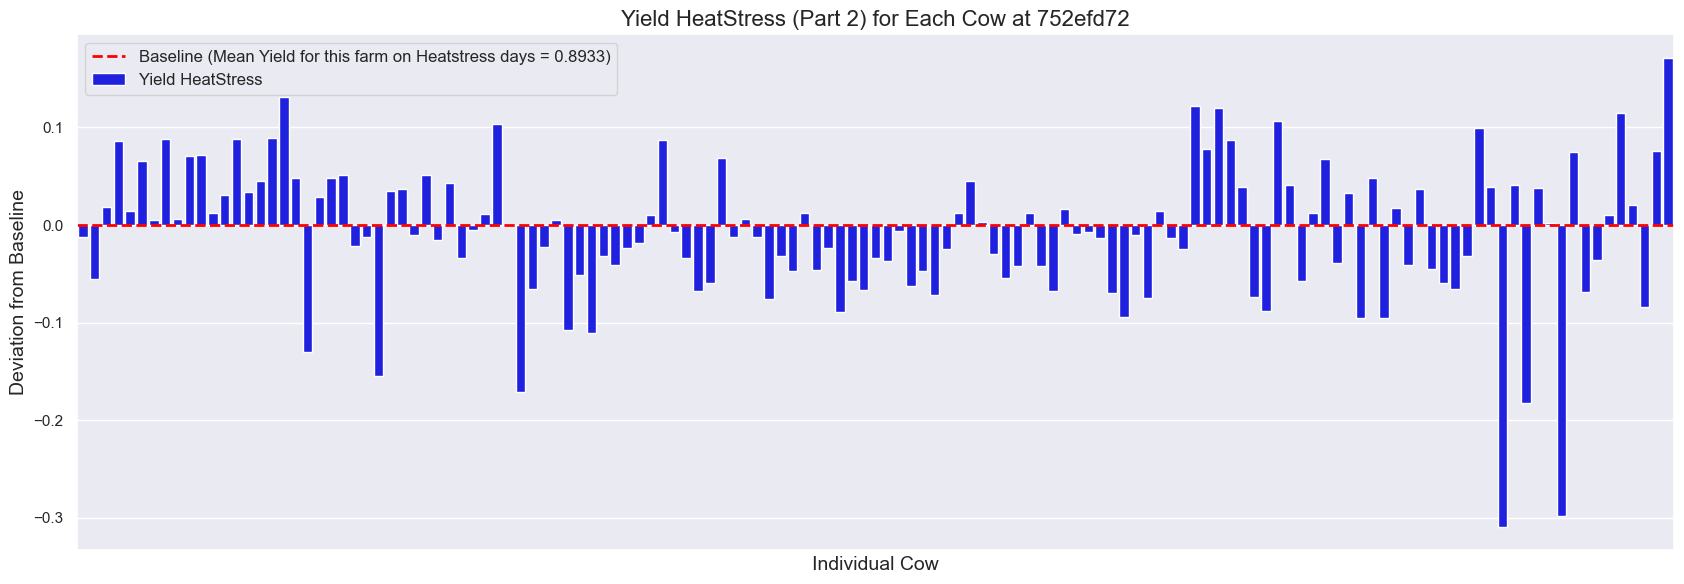

In [13]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

In [15]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# Calculate the baseline mean for NormalizedDailyYield
baseline_mean = daily_farm_data['NormalizedDailyYield'].mean()

# List to store model instances and results for each cow
models = []
results = []

# Function to optimize hyperparameters using Optuna
def objective(trial, train_data, target):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 15),
    }

    model = xgb.XGBRegressor(**param)
    scores = cross_val_score(model, train_data, target, cv=3, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    return mse

# Function to fit XGBoost model on data for each cow and calculate yield change
def fit_xgboost_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Check if there's enough data for the cow
        if len(cow_data) < 10:  # Minimum number of data points for training
            continue
        
        # Split the data into train and test sets
        train_data, test_data = train_test_split(cow_data, test_size=0.3, random_state=42)
        
        # Define the feature and target
        features = train_data[[feature]]
        target = train_data['NormalizedDailyYield']
        
        # Optimize hyperparameters using Optuna
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, features, target), n_trials=50)
        best_params = study.best_params
        
        # Train final model using the best parameters
        best_model = xgb.XGBRegressor(**best_params)
        best_model.fit(features, target)
        
        # Store the model instance
        models.append(best_model)
        
        # Predictions and evaluation on the test set
        y_pred = best_model.predict(test_data[[feature]])
        mse = mean_squared_error(test_data['NormalizedDailyYield'], y_pred)
        
        # Estimation of average milk production during heat stress
        average_production_heat_stress = y_pred.mean()
        
        # Calculate the reduction compared to baseline
        reduction = ((baseline_mean - average_production_heat_stress) / baseline_mean)
        
        # Store results
        results.append({
            'SE_Number': cow,
            'MSE': mse,
            'Yield HeatStress': average_production_heat_stress,
            'Reduction': reduction
        })
    
    return results

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_xgboost_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame(yield_changes_heatstress)
results_df

,SE_Number,MSE,Yield HeatStress,Reduction
0,SE-a2bab923-0680,0.083289,1.011952,-0.013830
1,SE-f454e660-0139,0.055963,1.013929,-0.015810
2,SE-f454e660-0157,0.097418,1.059780,-0.061746
3,SE-f454e660-0235,0.028892,0.975489,0.022701
4,SE-f454e660-0250,0.105279,1.098991,-0.101030
...,...,...,...,...
180,SE-f454e660-693,0.055993,0.899249,0.099083
181,SE-f454e660-701,0.075095,1.009502,-0.011375
182,SE-f454e660-714,0.155648,1.098770,-0.100808
183,SE-f454e660-735,0.124972,0.829508,0.168954


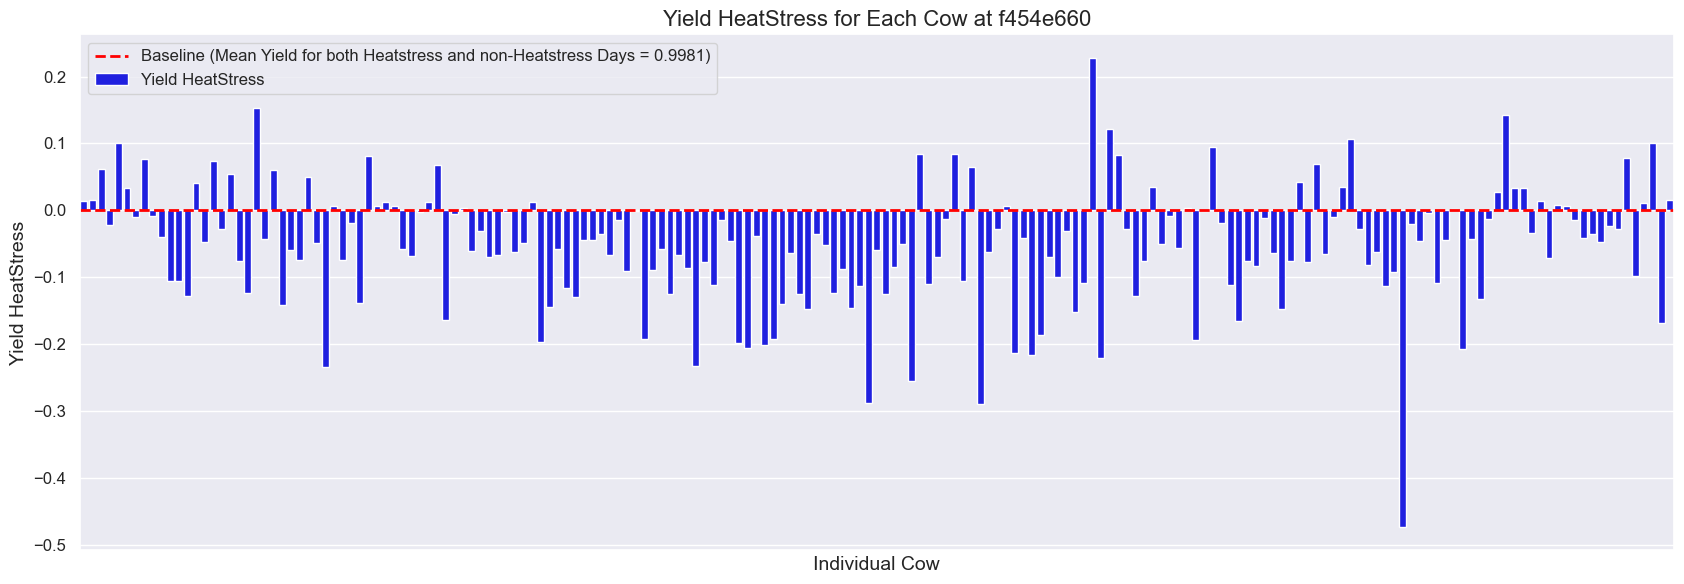

In [16]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

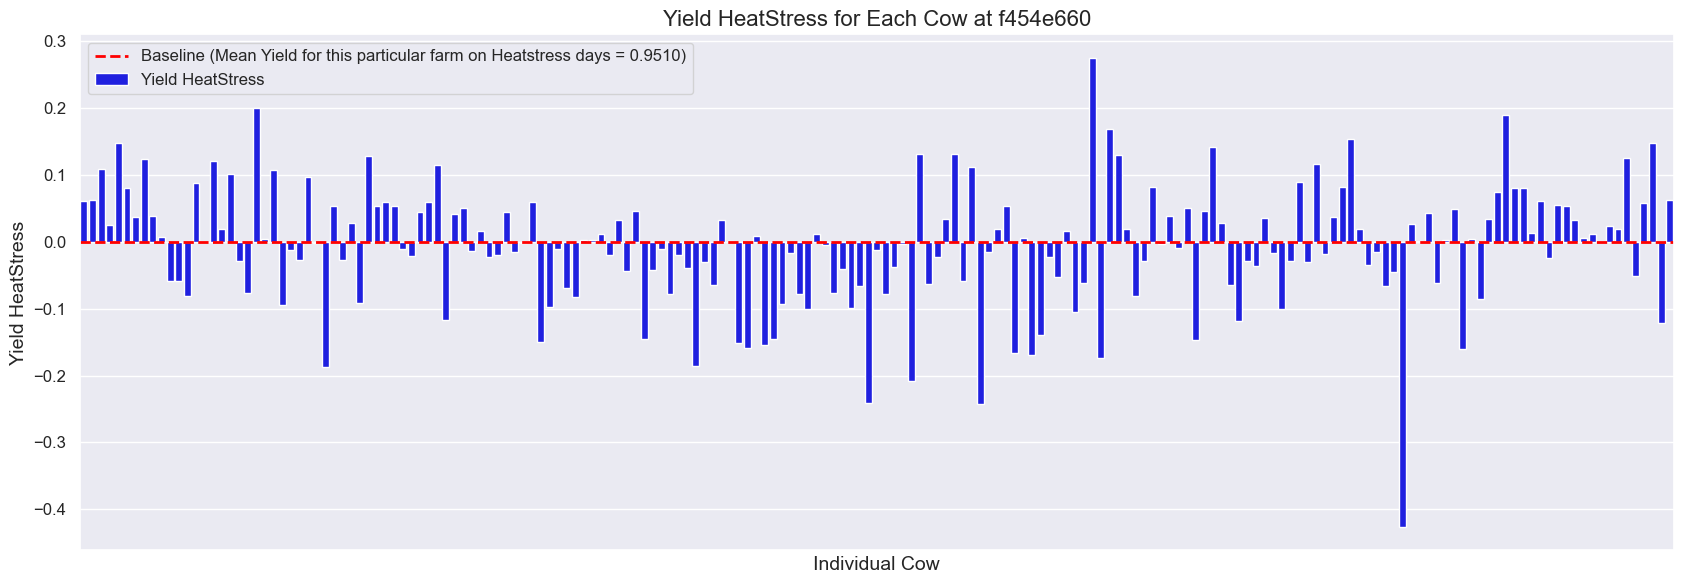

In [17]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()